# Damping, Smoothing, and Filtering

This notebook demonstrates how filtering (aka damping) works in the processing of data from the boat.

First we will observe that many of the signals including apparent wind angle and speed (AWA and AWS), as well as boat speed (SPD) are quite "noisy".

Glossary

- AWA: apparent wind angle (directly measured at the mast head, fast but noisy)
- AWS: apparent wind speed (same)
- SPD: boat speed measured with the paddle speedo in the hull (fast and noisy)
- HDG: compass heading (on PG this is magnetic and not true).
- TWS: true wind speed (computed from the above quantities using the "wind triangle").
- TWA: true wind angle (same)
- TWD: is really just TWA + HDG (though more on this below)
- COG and SOG: course and speed over ground from the GPS (these are relative to true north not magnetic on PG).

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import process as p
import analysis as a
import chart as c
import global_variables as G
from utils import DictClass

In [2]:
example = DictClass(log='2019-10-12_09:45.pd', doc='CYC PSSC Day 1', begin=19081, end=233893)
example = DictClass(log='2019-11-16_10:09.pd', doc='Snowbird #1.', begin=42548, end=111668)
sail_logs = [example.log]

dfs, bdf = p.read_sail_logs(sail_logs, discard_columns=True, skip_dock_only=False, trim=True, path=G.DATA_DIRECTORY, cutoff=0.3)
df = dfs[0]


Session from 2019-11-16 18:09:15.020000, 128865 rows, 3.5797222222222222 hours.


<IPython.core.display.Javascript object>


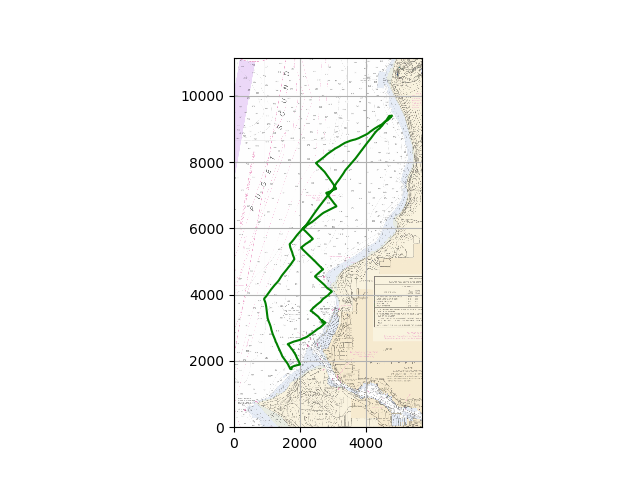

In [3]:
# Snowbird #1 was a day when we battled with Creative on the upwind from the last 
# mark to the finish
chart = c.plot_chart(df)
race_df = df.loc[example.begin : example.end]
c.draw_track(race_df, chart, color='green')

<IPython.core.display.Javascript object>


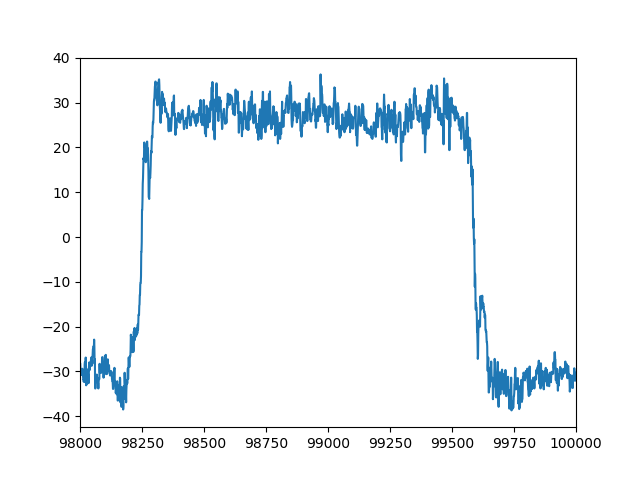

In [4]:
# Let's just look at a bit of data, 200 seconds from the middle, 
# note their are 10 samples per second, so we are grabbing 2000 points.
wide_slice = slice(98000, 100000)
wdf = df.loc[wide_slice]
plt.figure()
# RAWA is the raw values of AWA that are logged
wdf.rawa.plot()


<IPython.core.display.Javascript object>


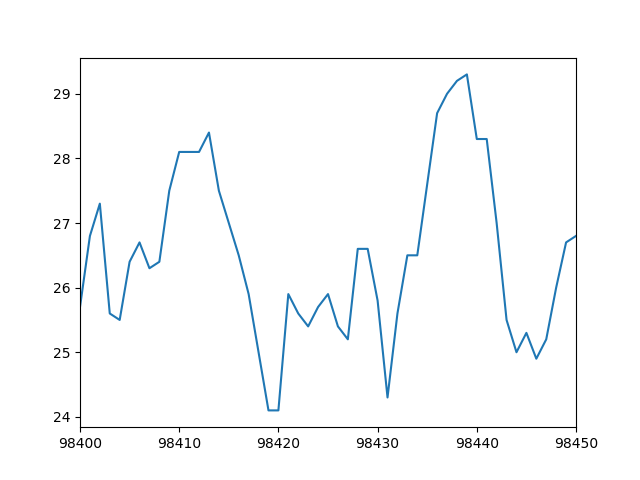

In [5]:
# Let's drill down and look at 5 seconds (50 samples)
narrow_slice = slice(98400, 98450)
ndf = df.loc[narrow_slice]
plt.figure()
ndf.rawa.plot()

### Is this noise?

Noise is pure randomness, there is no structure and no clear physical explanation.

But in the above signal the rough oscillation frequency is 2Hz.  Most likely this is **not** noise.  Remember that the wind sensor is at the top of the mast, 50 feet above the water, where small changes in boat heel can lead to large and rapid movement side to side.  As the boat cuts through rhythmic waves, it is plausible that regular oscilation in wind angle would result.

But is the useful information?  Probably not.  Neither the boat, nor the wind, is rotating 5 degrees in 0.4 seconds.  So these variations might as well be noise, and we are better of "filtering" them away.

The effective AWA is hidden in this noise; if you were to display the raw wind sensor readings the numbers would be jumping around like crazy, almost impossible to read.  (On many boats you can adjust display settings to display the raw instrument readings.  Its not very useful.)

On our B&G boat, these issues are addressed by "damping", which is left a bit mysterious in the Triton and Zeus B&G documentation.  Damping is a number from 0 to 10, with higher numbers providing more filtering and less noise, while also introducing significant delay.  Further information on signal processing is provided in the documentation for some of the more advanced B&G sail computers: H5000 and WTP3.  Most likely the onboard units are using exponential filtering, perhaps a non-linear version.

Note, that what is logged for AWA is not what is shown on the display, because the sensors broadcast raw AWA while the displays compute a damped version, which is not logged.

The logged values for true wind angle (TWA) are damped. On Peer Gynt, TWA (and TWS and TWD) are computed and broadcast by the autopilot computer (if the autopilot is off, then it missing from the logs).  These are damped **before** they are sent to other devices, including our logging device.

Since TWA is closely related to AWA, let's plot them both to get a sense of how damping works.

<IPython.core.display.Javascript object>


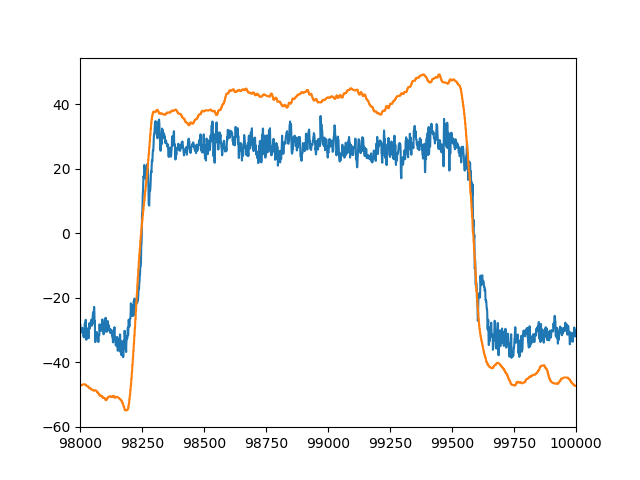

In [6]:
plt.figure()
# RAWA is the raw values of AWA that are logged
wdf.rawa.plot()
# And the "raw" TWA that is logged is quite different and much smoother.
wdf.rtwa.plot()

For more information on sailing instruments the book *Sail Smart: Understand Your Instruments to Sail Faster, Make the Right Calls & Win Races* by Mark Chisnell provides quite a bit of helpful info on boat instruments and measurements. [link](https://www.amazon.com/dp/B07F3CKRLH/ref=cm_sw_em_r_mt_dp_U_Px-gEbZJ52RTX)

Note, AWA, AWS, and SPD are directly measured by instruments on the boat.  

Apparent wind conflates the "true wind" and the boat movement.  If the boat were stationary (e.g. at the dock) the apparent wind and the true wind are the same (both in speed and direction).  But if the boat is moving it introduces another "wind" which is equal and opposite to the boat's speed and direction.  True wind is an attempt to subtract the boat's contribution.

True wind is more consistent and drives the strategy that you use to race around the course.  Note TWA is reported relative to the boat, and TWD is reported relative to true north. We will see that they are otherwise the same.

We can compute the TWA from AWA/AWS/SPD using the code below.  My favorite way to do this is to separate the two components of the apparent wind: i) the wind along the boat (which I think of as "local north") and ii) the wind perpedicular to the boat (local east).  The boat spd is then subtracted from local north (since local the boat is assumed to be moving forward in the local north coordinates). All of this can be transformed into global north by adding the boats heading (which we will not do here).  Note, heading (HDG) is typically given in magnetic coordinates, not world, so be careful to add in the magnetic variation.

<IPython.core.display.Javascript object>


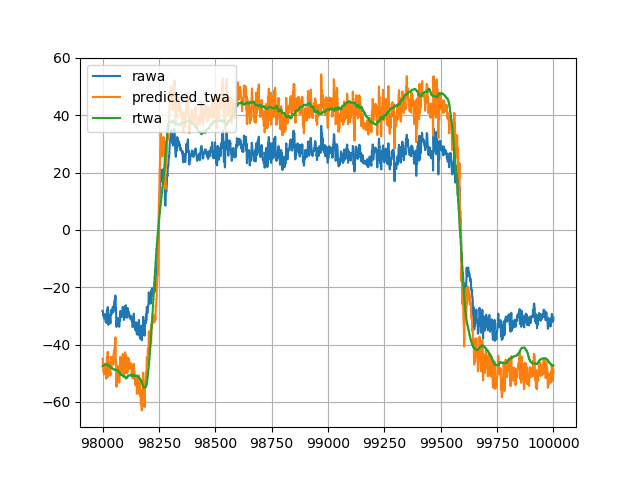

In [35]:
# Note, TWA is computed from AWA, AWS, and boat speed (SPD)
#
# This is "local" north, not global
tw_north = p.cos_d(df.rawa) * df.raws - df.rspd
tw_east = p.sin_d(df.rawa) * df.raws
df['predicted_twa'] = np.degrees(np.arctan2(tw_east, tw_north))
wdf = df.loc[wide_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.predicted_twa, wdf.rtwa), "rawa predicted_twa rtwa".split())

There is general agreement between boat computed TWA and the "predicted TWA" using our formulas.  But there is a huge difference in noise.  The boat TWA is clearly filtered to remove noise.  

I am very impressed (or perhaps surprised) that the TWA computed on the boat seems to be **ahead** of the predicted TWA at the rise. Smoothing always introduced some delay.  I do not have a great explanation for this. (More below. The TWA actually seems to move before AWA, which and seems to line up with heading...).

How is smoothing computed?

Is the smoothing done to AWA, AWS, and SPD before combination, or only after?

I started out by implementing a number of classical smoothing filters, my favorite being the [Butterworth](https://en.wikipedia.org/wiki/Butterworth_filter).  The Butterworth is a [causal](https://en.wikipedia.org/wiki/Causal_filter) optimal linear filter, but there is no point where a single filter can both smooth out the local noise and track the large jumps.  Butterworth also introduces quite a bit of delay.

<IPython.core.display.Javascript object>


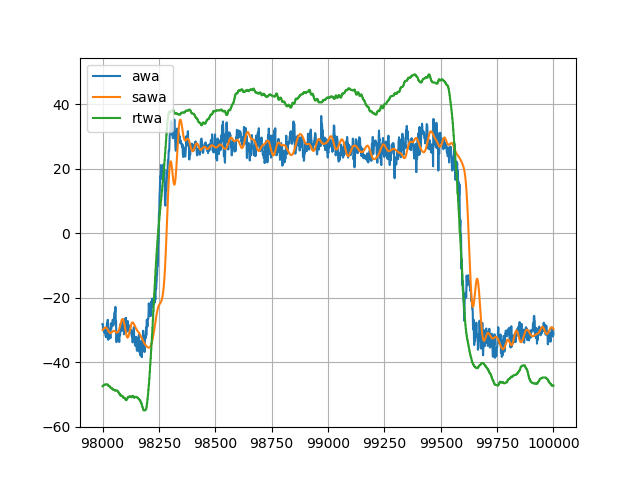

In [36]:
coeff = p.butterworth_filter(cutoff=0.3, order=5)

df['butter_causal_awa'] = p.smooth_angle(coeff, df.rawa, causal=True)
wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rawa, wdf.butter_causal_awa, wdf.rtwa), "awa sawa rtwa".split())

Notice that the Butterworth signal is both more wiggly **and** very delayed (perhaps 4 seconds). We can reduce the noise (remove wiggles) but that increases delay.  Delay can be reduced, but the noise grows in response.

<IPython.core.display.Javascript object>


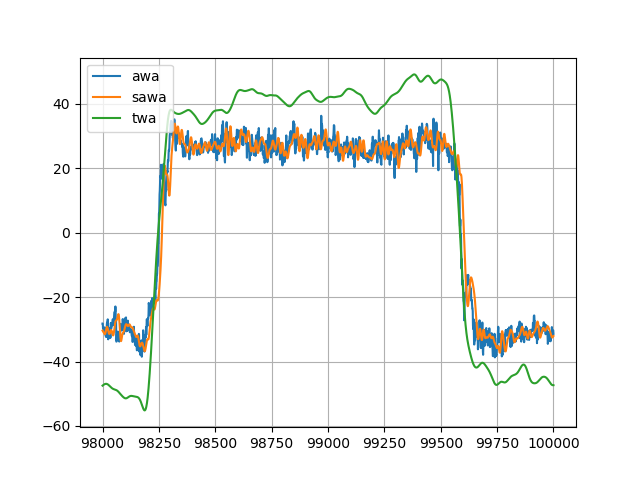

In [37]:
coeff = p.butterworth_filter(cutoff=0.7, order=5)

df['butter_causal_awa'] = p.smooth_angle(coeff, df.rawa, causal=True)
wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rawa, wdf.butter_causal_awa, wdf.twa), "awa sawa twa".split())

To eliminate the delay there is a non-causal trick one can use, which is to first filter forward and then backward.  But this **cannot** be what is used on the boat in real-time.  My motivation is to understand what the boat does, and to create algorithms that might be used on the boat.

After digging through various writings on boat instrument processing I discovered an offhand comment regarding non-linear filtering.  The basic idea is to implement a non-linear version of a simple recursive filter 

$$ o_{t} = \alpha o_{t-1} + (1 - \alpha) i_t $$

where $o_t$ is the output and $i_t$ is the input.  Larger values of $\alpha$ (up to 1.0) yield more smoothing.  

This sort of filter is very easy to implement,  but they are also primitive, providing poor filtering of noise.  If you want good filtering, then the signal is delayed (perhaps worse than a Butterworth).  Below is the basic recursive filter.

<IPython.core.display.Javascript object>


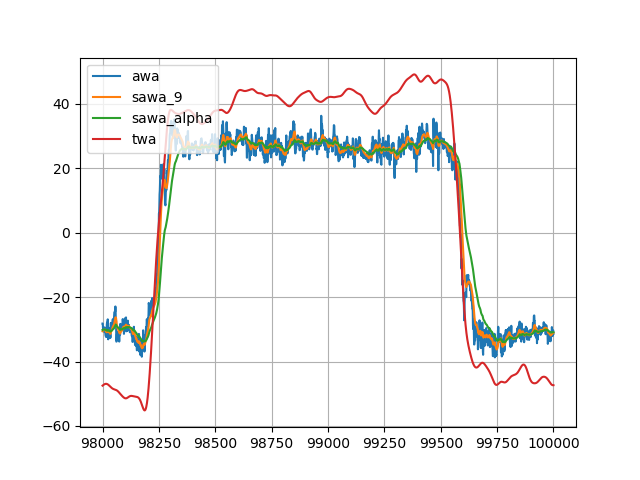

In [12]:
# Ignore the mysterious parameter of 10,000 for now.  Explained below.
df['sawa_9'], _ = p.exponential_filter_angle(np.array(df.rawa), 0.9, 10000)
alpha = 0.97
df['sawa_alpha'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, 10000)
wdf = df.loc[wide_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa_9, wdf.sawa_alpha, wdf.twa), "awa sawa_9 sawa_alpha twa".split())


The large value of alpha is pretty good for filtering, but it introduces a **huge** delay!

So far this is all linear.  The non-linear version introduces a tracking error threshold.  If the difference between the filtered output and the raw input is larger than this threshold then dynamically reduce the value of alpha.  If the tracking error is less than threshold than dynamically increase the threshold (back to the original).

There are a couple of magic numbers here, like how much to decrease or increase the value of alpha (which are hard to set).  Code is below.  Note, I could not figure out a good way to do this with Numpy magic (which makes things fast in Python).  The result is a very slow Python loop.  I sped this up with the Numba package for compiling Python functions.

The code for doing with with angles is a bit more complex (angles wrap around at 360).  Below is the simpler (non-angle) version.

Why is this a good filter?  The filter is trying to separate the noise from the underlying signal. It is plasible that the underlying signal is mostly changing slowly, with additional large steps (something like a square wave).  If you had advanced knowledge of the regime (slow or step) then you could use two values of alpha, say 0.99 for the smooth regions and 0.5 for the steps.  The non-linear exponential filter flips between the regimes by looking at the output of the filter.  If the tracking is poor then the signal must be in the step regime, so alpha is reduced.  If tracking is good then alpha trends back to 0.99.

The Butterworth is stuck processing both regimes using the same parameters.

Note, AWA is sort of like this.  Tacks and gybes introduce big changes, but otherwise you sail on a consistent wind angle.  Tacks and gybes introduce changes in AWS and SPD as well,  though less dramatically.

I suppose this could be justified by a two state hidden markov model (HMM) which could work along similar lines.  

In [13]:
def exponential_filter(sig, alpha, max_error):
    """
    Apply a non-linear exponential filter, where alpha is the decay (higher alpha is longer decay and higher smoothing).  If the error is
    greater than max_error, then alpha is repeatedly reduced  (faster decay).
    """
    beta = beta0 = 1 - alpha
    res = np.zeros(sig.shape)
    betas = np.zeros(sig.shape)
    res[0] = sig[0]
    betas[0] = beta
    for i in range(1, len(sig)):
        res[i] = (1 - beta) * res[i-1] + beta * sig[i]
        if np.abs(res[i] - sig[i]) > max_error:
            beta = min(1.5 * beta, 0.5)
        else:
            beta = (beta + beta0) / 2
        betas[i] = beta
    return res, betas

<IPython.core.display.Javascript object>


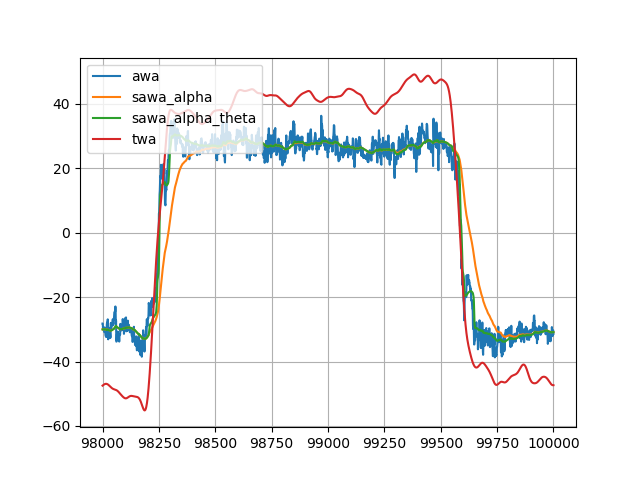

<IPython.core.display.Javascript object>


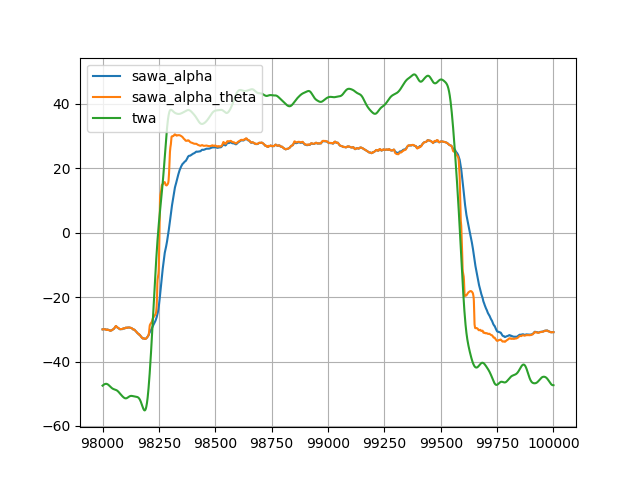

In [15]:
# Now the last parameter can be defined, it is the max error.  This is max_tracking_error threshold.
theta = 6  # the threshold, which should be approximate the noise 
alpha = 0.98
df['sawa_alpha'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, 10000)
df['sawa_alpha_theta'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, theta)
wdf = df.loc[wide_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa_alpha, wdf.sawa_alpha_theta, wdf.twa), "awa sawa_alpha sawa_alpha_theta twa".split())
c.quick_plot(wdf.index, (wdf.sawa_alpha, wdf.sawa_alpha_theta, wdf.twa), "sawa_alpha sawa_alpha_theta twa".split())


<IPython.core.display.Javascript object>


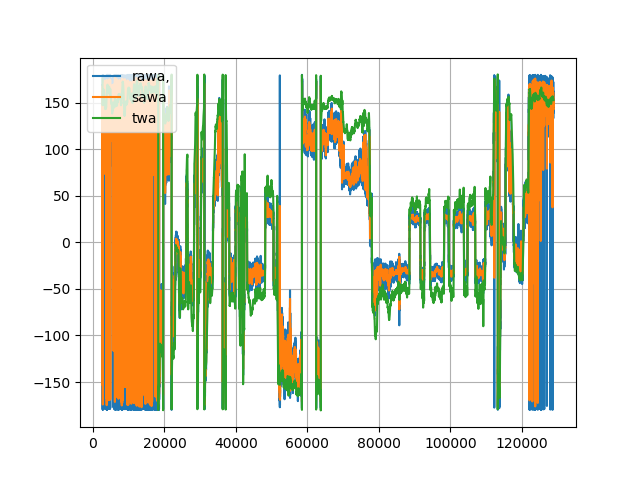

<IPython.core.display.Javascript object>


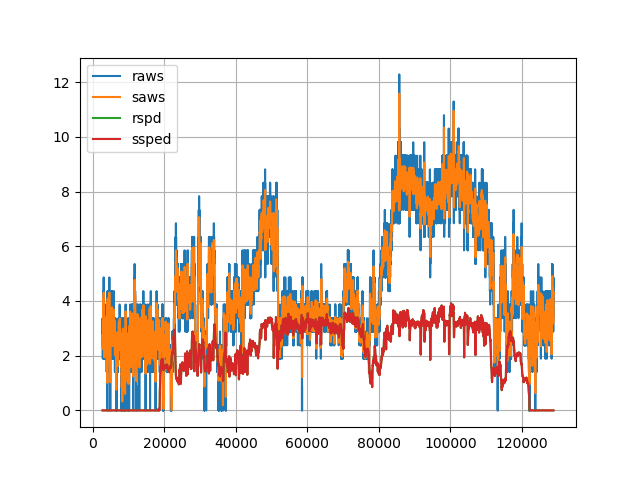

In [16]:
# Note the different signals require different settings of alpha, because they have different 
# dynamics and noise.
df['sawa'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, theta)
# Less noise and smaller values.  Theta is much smaller.
df['saws'], _ = p.exponential_filter(np.array(df.raws), 0.96, 0.8)
df['sspd'], _ = p.exponential_filter(np.array(df.rspd), 0.8, 0.5)

c.quick_plot(df.index, (df.rawa, df.sawa, df.twa), "rawa, sawa twa".split())
c.quick_plot(df.index, (df.raws, df.saws, df.rspd, df.sspd), "raws saws rspd ssped".split())

<IPython.core.display.Javascript object>


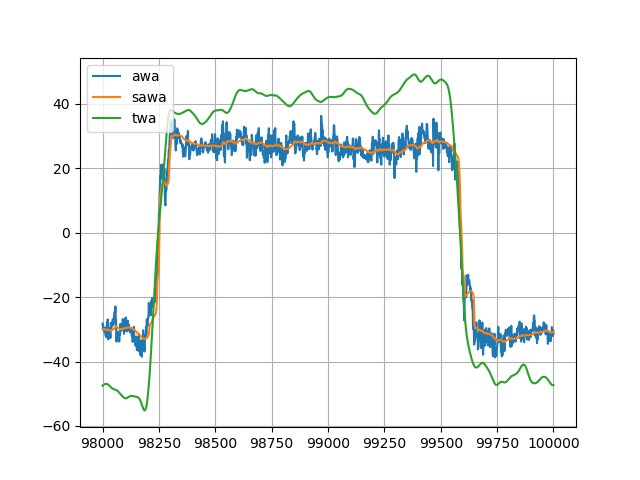

<IPython.core.display.Javascript object>


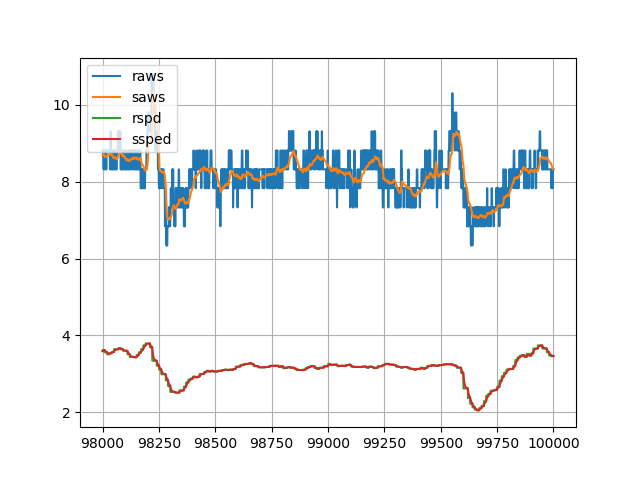

In [17]:
wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa, wdf.twa), "awa sawa twa".split())
c.quick_plot(wdf.index, (wdf.raws, wdf.saws, wdf.rspd, wdf.sspd), "raws saws rspd ssped".split())

In [23]:
tw_north = p.cos_d(df.rawa) * df.raws - df.rspd
tw_east = p.sin_d(df.rawa) * df.raws
predicted_twa = np.degrees(np.arctan2(tw_east, tw_north))

tw_north = p.cos_d(df.sawa) * df.saws - df.sspd
tw_east = p.sin_d(df.sawa) * df.saws
df['predicted_stwa'] = np.degrees(np.arctan2(tw_east, tw_north))

df['spredicted_twa'], _  = p.exponential_filter_angle(np.array(predicted_twa), alpha, theta)
df['spredicted_stwa'], _  = p.exponential_filter_angle(np.array(df.predicted_stwa), alpha, theta)

<IPython.core.display.Javascript object>


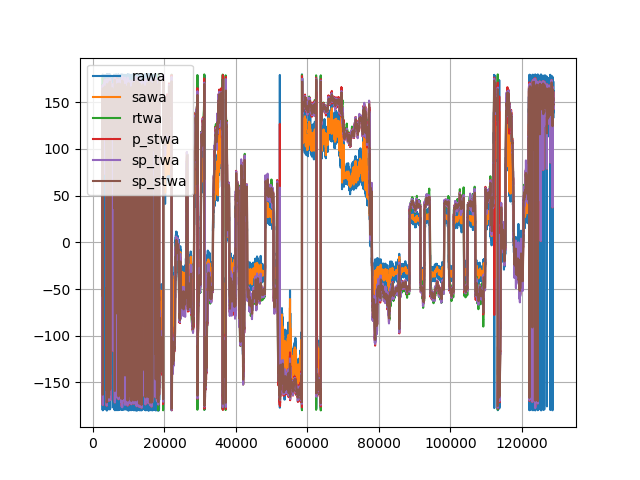

<IPython.core.display.Javascript object>


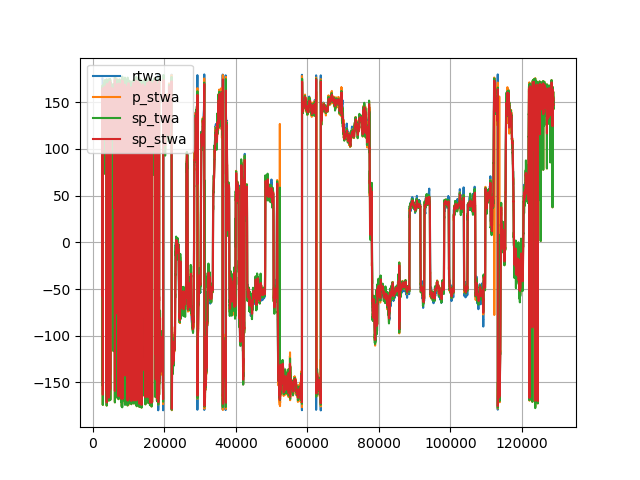

<IPython.core.display.Javascript object>


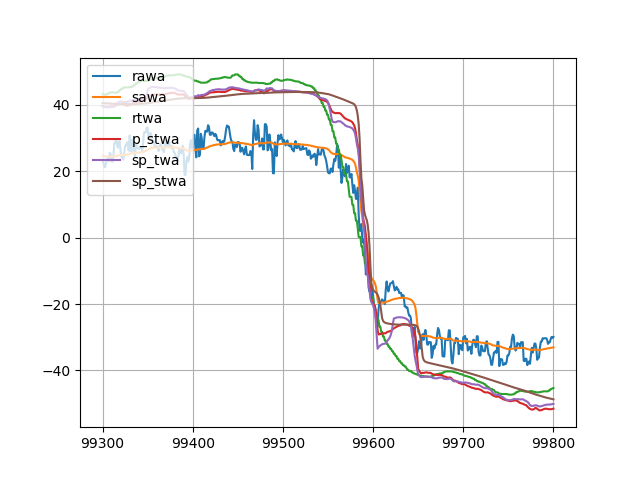

In [33]:
wdf = df
c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa, wdf.rtwa, wdf.predicted_stwa, wdf.spredicted_twa, wdf.spredicted_stwa),   
            "rawa sawa rtwa p_stwa sp_twa sp_stwa".split())
c.quick_plot(wdf.index, (wdf.rtwa, wdf.predicted_stwa, wdf.spredicted_twa, wdf.spredicted_stwa),   
            "rtwa p_stwa sp_twa sp_stwa".split())

tack_slice = slice(99300, 99800)
wdf = df.loc[tack_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa, wdf.rtwa, wdf.predicted_stwa, wdf.spredicted_twa, wdf.spredicted_stwa),   
            "rawa sawa rtwa p_stwa sp_twa sp_stwa".split())

<IPython.core.display.Javascript object>


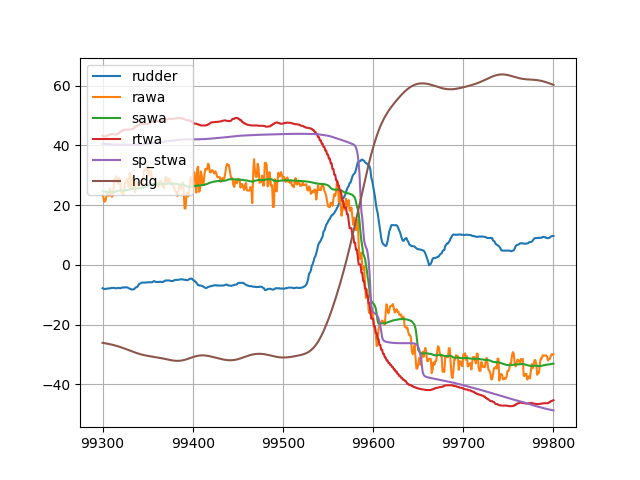

In [34]:
wdf = df.loc[tack_slice]
c.quick_plot(wdf.index, (wdf.rudder, wdf.rawa, wdf.sawa, wdf.rtwa, wdf.spredicted_stwa, wdf.hdg-160),   
            "rudder rawa sawa rtwa sp_stwa hdg".split())

# Note that TWA seems to be **leading** AWA!
# Note the clear agreement between RTWA (from the boat) and heading!

In [47]:
def least_square_fit(target, signal):
    "Compute the least squares fit of target from signal."
    a = np.vstack((signal, np.ones((len(signal))))).T
    b = np.asarray(target)
    fit = np.linalg.lstsq(a, b, rcond=None)[0]
    predictions = a.dot(fit)
    return fit, predictions

<IPython.core.display.Javascript object>


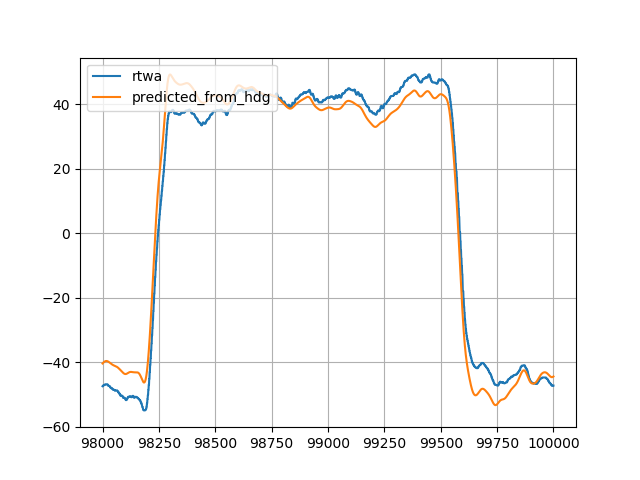

In [69]:
# Let's try to predict the TWA from HDG alone ?!?!!?
fit, pred = least_square_fit(wdf.rtwa, wdf.hdg)
c.quick_plot(wdf.index, (wdf.rtwa, pred), "rtwa predicted_from_hdg".split())

In [70]:
fit

array([ -1.0171, 174.277 ])

Why is it possible to predict TWA from HDG alone?  The assumption is that TWA = TWD - HDG and that TWD is varying very slowly.  The time period above is 2000/10 = 200 seconds.  During this period TWD must have been approximately 174 degrees.


### Is the Boat really Smart??

What is going on here?  Why does the change in TWA come ahead of the change in AWA?  Why does it seem to track HDG almost perfectly?

Perhaps the above analysis is too simplistic.

If I were to estimate true wind with no real limitations, I would create a filter for the signal that I felt was the most phyically relistic and well understood.  That would be TWD/TWS (true wind direction and speed).  This is a quantity of the **world**, and while it varies with time, these processes do not depend on the boat. 

The boat and its sensors provide noisy observations for estimating TWD/TWS.  TWA can then be computed from TWD, by subtracting heading (not the other way around!).

This explains why TWA can lead AWA.  Why wait for the AWA, which is noisy, to stabilize when the HDG is measured very accurately, with low noise (with a compass)?  TWD is likely consistent through the tack, so as HDG changes TWA does as well.
